In [82]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from sklearn.model_selection import train_test_split

In [83]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [84]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    mask = mask[y:y+height, x:x+width]
    return img, mask

In [85]:
def padding(array, xx, yy):
        h = array.shape[0]
        w = array.shape[1]
        a = (xx - h) // 2
        aa = xx - a - h
        b = (yy - w) // 2
        bb = yy - b - w
        return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [86]:
def get_data(img_path,mask_path,num_imgs):
    full_original_imgs = []
    full_original_masks = []
    for i in range(num_imgs):
        print(str(i) + '/' + str(num_imgs))
        file_path = img_path + '\\' + str(i) + '.tif'
        image = tifffile.imread(file_path)
        image = np.squeeze(image)
        full_original_imgs.append(image)

        file_path = mask_path + '\\' + str(i) + '.tif'
        mask = tifffile.imread(file_path)
        mask = np.squeeze(mask)
        full_original_masks.append(mask)

    initial_data = []
    for i in range(len(full_original_imgs)):
        print(str(i) + '/' + str(len(full_original_imgs)))
        img = full_original_imgs[i]
        images = [img[:, :, 0],img[:, :, 1],img[:, :, 2],img[:, :, 3]]   
        initial_data.append((full_original_masks[i],images))

    cropped_imgs = []
    cropped_masks = []
    
    j = 0
    for data in initial_data:
        print(str(j) + '/' + str(len(initial_data)))
        j += 1
        mask = data[0]
        images = data[1]
        for img in images:
            for i in range(500):
                crop_width = random.randint(5,250)
                crop_height = random.randint(5,250)
                crop_img, crop_mask = randomCrop(img, mask, crop_width, crop_height)
                crop_img = torch.from_numpy(crop_img.astype(np.float))
                crop_mask = torch.from_numpy(crop_mask.astype(np.float))
                cropped_imgs.append(padding(crop_img,250,250))
                cropped_masks.append(padding(crop_mask,250,250))

    return cropped_imgs, cropped_masks

In [87]:
def get_train_test_data(img_path, mask_path, num_imgs, test_size=0.3):
    img_data, mask_data = get_data(img_path, mask_path, num_imgs)
    X_train, X_test, y_train, y_test = train_test_split(img_data, mask_data, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [88]:
img_path = os.getcwd() + '\812_plate'
mask_path = os.getcwd() + '\812_plate_masks'
img_data, mask_data = get_data(img_path, mask_path, 1)

print(img_data[0].shape)

print('Num imgs:',len(img_data))
print('Num masks:',len(mask_data))

0/1
0/1
0/1


C:\Users\rz200\AppData\Local\Temp\ipykernel_34312\945872252.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_34312\945872252.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


(250, 250)
Num imgs: 2000
Num masks: 2000


In [89]:
X_train, X_test, y_train, y_test = get_train_test_data(img_path, mask_path, 2)

0/2
1/2
0/2
1/2
0/2


C:\Users\rz200\AppData\Local\Temp\ipykernel_34312\945872252.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_img = torch.from_numpy(crop_img.astype(np.float))
C:\Users\rz200\AppData\Local\Temp\ipykernel_34312\945872252.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  crop_mask = torch.from_numpy(crop_mask.astype(np.float))


1/2


In [134]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import ReLU

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 4)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 4)
	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x))) #CONV->RELU->CONV

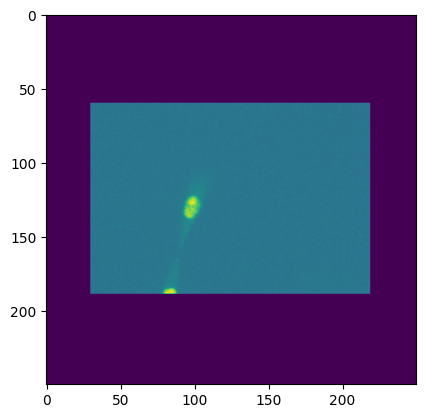

<class 'torch.Tensor'>


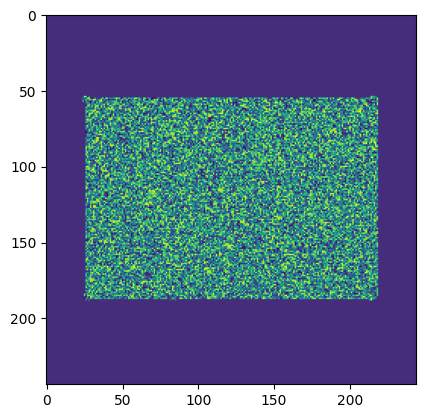

In [137]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,250)),
	transforms.ToTensor()])

image = X_train[2].astype(int)
plt.imshow(np.squeeze(image))
plt.show()
image = transforms(image)
print(type(image))

b = Block(1,1)
output = b.forward(image.float())
output = ToPILImage()(output)
plt.imshow(output)
plt.show()

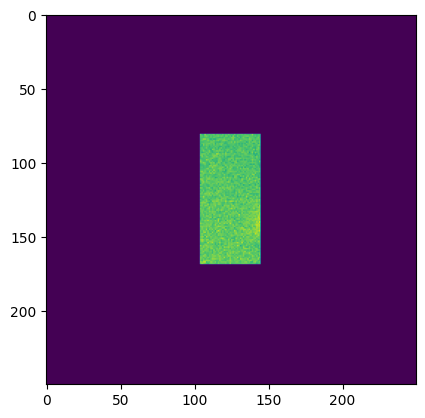

<class 'torch.Tensor'>
torch.Size([1, 1, 250, 250])


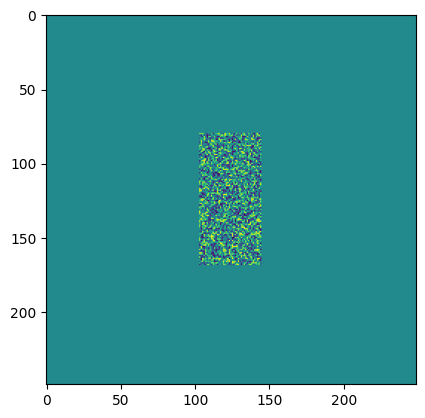

In [129]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor

transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((250,250)),
	transforms.ToTensor()])

image = X_train[0].astype(int)
plt.imshow(np.squeeze(image))
plt.show()
image = transforms(image)
print(type(image))

conv_ex = Conv2d(1,1,2)
image = image.unsqueeze(0)
print(image.size())
output = conv_ex(image.float())
output = output.squeeze(0)
output = ToPILImage()(output)
plt.imshow(output)

In [ ]:
b = Block(1,1)

img = X_train[0]
img = np.moveaxis(img, -1, 0)
x_data = torch.from_numpy(img)
x_data = x_data.unsqueeze(0)

img = b.forward(x_data)

In [ ]:
plt.imshow(X_train[0])

In [ ]:
#input = torch.empty(2,2,4,4).random_(256)

img = X_train[0]
img = np.moveaxis(img, -1, 0)
x_data = torch.from_numpy(img)
x_data = x_data.unsqueeze(0)
print(x_data.size())

conv_ex = Conv2d(1,3,2)
output = conv_ex(x_data)

plt.imshow(output)

In [ ]:
conv_ex = Conv2d(2,3,2)
x = random.random((25,25,1))
output = conv_ex(x)

In [ ]:
from numpy import random

b = Block(1,1)
x = random.random((25,25,3))
plt.imshow(x)
plt.show()
b.forward(x)